# PCA with a linear Autoencoder

Importing stuff


In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import tensorflow as tf

Building a 3D dataset

In [5]:
rnd.seed(4)
m = 200
w1, w2 = 0.1,0.3
noise = 0.1

angles = rnd.rand(m) * np.pi / 2 - 0.5
data = np.empty((m,3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m)/2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.random(m) /2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

Normalization

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(data[:100])
x_test = scaler.transform(data[100:])

Building the autoencoder

In [7]:
import tensorflow as tf

tf.reset_default_graph()

n_inputs = 3
n_hidden = 2 # codings
n_outputs = n_inputs

lr = 0.01

x = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(x, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - x))

optimizer = tf.train.AdamOptimizer(lr)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [8]:
from tqdm import tqdm
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in tqdm(range(n_iterations)):
        training_op.run(feed_dict={x:x_train})
    codings_val = codings.eval(feed_dict={x:x_test})

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2173.95it/s]


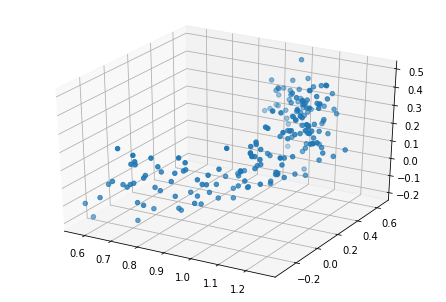

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(data[:,0], data[:,1], data[:,2], cmap='Greens')

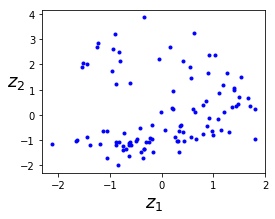

In [8]:


fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:,1],"b.")
plt.xlabel("$z_1$", fontsize= 18)
plt.ylabel("$z_2$", fontsize= 18, rotation = 0)
plt.show()

# Stacked Autoencoders

In [9]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Here <b>He</b> is an <b>initialization technique</b> where we multiply random initialization with <br><br>
$
√2∕size[l-2]
$
<br><br>
W[l] = np.random.randn(size_l, size_l-1)*np.sqrt(2/size_l - 1)
<br><br>
And the <b>activation function</b> tf.nn.elu = <b>Exponential Linear Unit (ELU)</b> is a function that tend to converge cost to zero faster and produce more accurate results. Different to other activation functions, ELU has a extra alpha constant which should be positive number.
<br>
 
$
R(z) = z ,z>0 
$
 
$
R(z) = α(e^z - 1) , z<=0
$


In [10]:
from functools import partial # A cool stuff used to create parametric instances of a function

n_inputs = 784
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

lr = 0.01
l2_reg = 0.0001

x = tf.placeholder(tf.float32, shape=[None, n_inputs])
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

hidden1 = dense_layer(x, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - x)) # Mean Square Error

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(lr)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training

In [11]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={x: x_batch})
        loss_train = reconstruction_loss.eval(feed_dict={x: x_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

0%

NameError: name 'sys' is not defined

## Visualize reconstructions

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image, shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation = "nearest")
    plt.axis("off")
    
def show_reconstruction(x, outputs, model_path=None, n_test_digits = 4):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        x_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={x:x_test})
        
    fig = plt.figure(figsize =(5,2 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(x_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [ ]:
show_reconstruction(x, outputs, "./my_model_all_layers.ckpt")


# Tying Weights

When a autoencoder is symmetrical we can tie the weights together of the decoder layers to that of encoders. Which might help us in reducing the risk of overfitting and lowering the training time.<br>
But this makes it quite challenging to use the tf.layers.dense() function, so we need to build the Autoencoder manually

In [ ]:
tf.reset_default_graph


n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [ ]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
saver = tf.train.Saver()

In [ ]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

In [ ]:
show_reconstruction(X, outputs, "./my_model_tying_weights.ckpt")

# Training one Autoencoder at a time in multiple graphs